In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.neighbors import LocalOutlierFactor

In [2]:
np.random.seed(0)

# Part I: Probabilistic and Statistical Models for Outlier Detection

## Univariate extreme-value analysis

### Markov inequality

Tail inequalities can be used in order to bound the probability that a value in the tail of a probability distribution should be considered anomalous.

The strength of a tail inequality depends on the number of assumptions made about the underlying random variable.

Fewer assumptions lead to weaker inequalities but such inequalities apply to larger classes of random variables.

For example, the **Markov** and **Chebychev** inequalities are weak inequalities but they apply to very large classes of random variables.

On the other hand, the **Chernoff** bound and **Hoeffding** inequality are both stronger inequalities but they apply to restricted classes of random variables.

**Theorem**: Let X be a random variable that takes on only non-negative random values. Then, for any constant $\alpha$ satisfying $E[X] < \alpha$, the following
is true: $$P(X > \alpha) \leq \frac{E[X]}{\alpha}$$

So for example you have some sample from a random variable that takes on only non-negative random values (say Log-normally distributed):

In [3]:
mean = 2
sigma = 0.7
sample = np.random.lognormal(mean=mean, sigma=sigma, size=10000)

(0, 140)

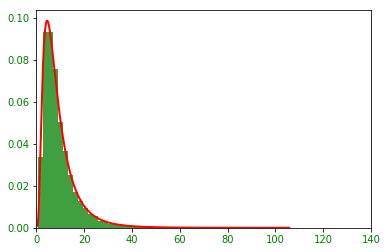

In [4]:
count, bins, ignored = plt.hist(sample, 50, normed=1, facecolor='g', alpha=0.75)

[i.set_color("green") for i in plt.gca().get_xticklabels()]
[i.set_color("green") for i in plt.gca().get_yticklabels()]

x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mean)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.xlim((0, 140))

In [5]:
plt.show()

In [6]:
values, base = np.histogram(sample, normed=True, bins=50)
cumulative = np.cumsum(values)

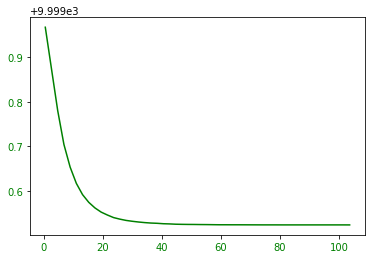

In [7]:
plt.plot(base[:-1], len(sample)-cumulative, c='green')
[i.set_color("green") for i in plt.gca().get_xticklabels()]
[i.set_color("green") for i in plt.gca().get_yticklabels()]
plt.show()

To be able to apply Markov inequality you need to know the true mean value (E[X]).

In our case E[X] is equal to 2.

All we need to do is to decide what number will be the threshold ($\alpha$) for outlier detection.

Suppose $\alpha$ is equal to 20.

Then according to Markov inequality $$P(X > 20) \leq \frac{1}{10}$$

Thus if we agreed that $\frac{1}{10}$ is appropriate borderline between inliers and outliers then we can use it to detect the last ones.

Pros:
- only one assumption sould be verified (non-negativity);
- only one true value should be known (mean);

Cons:
- it gives a threshold only for upper-tail;
- it doesn't give a [supremum](https://en.wikipedia.org/wiki/Infimum_and_supremum) for upper-tail boundary.

### Chebychev inequality

The **Markov** inequality is defined only for probability distributions of non-negative values and provides a bound only on the upper tail.

In practice, it is often desired to bound both tails of arbitrary distributions.

Consider the case where X is an arbitrary random variable, which is not necessarily non-negative.

In such cases the **Markov** inequality cannot be used directly.

However, the (related) **Chebychev** inequality is very useful in such cases.

The **Chebychev** inequality is a direct application of the **Markov** inequality to a non-negative derivative of random variable X

**Theorem:** Let X be an arbitrary random variable. Then, for any constant $\alpha$, the following is true:
$$P(\lvert X - E[X] \rvert > \lvert \alpha \rvert) \leq \frac{Var[X]}{\alpha^2}$$

So again in our case:
- E[X] = 2;
- Var[X] = 0.7;
- $\alpha$ = 20.

Then according to **Chebychev** inequality $$P(\lvert X - 2 \rvert >  20) \leq \frac{0.7}{20^2} = \frac{7}{4000}$$

As you can see **Chebychev** inequality gives significantly smaller probability for the same $\alpha$.

Pros:
- random variable doesn't have to be non-negative;
- it gives a threshold for both upper-tail and lower-tail;

Cons:
- true values of E[X] and Var[X] should be known;
- it doesn't give a
[supremum](https://en.wikipedia.org/wiki/Infimum_and_supremum)
and
[infimum](https://en.wikipedia.org/wiki/Infimum_and_supremum)
for upper-tail and lower-tail boundaries.

## Multivariate extreme-value analysis

### Mahalanobis Method

# Part II: Linear models for Outlier Detection

## One-Class SVM

One-Class SVM is an example of Unsupervised Outlier Detection.

The main issue this method is trying to solve can be described in following words:

first look at our problem situation; we would like to determine whether (new) test data is member of a specific class, determined by our training data, or is not.

Why would we want this? Imagine a factory type of setting; heavy machinery under constant surveillance of some advanced system.

The task of the controlling system is to determine when something goes wrong; the products are below quality, the machine produces strange vibrations or something like a temperature that rises.

It is relatively easy to gather training data of situations that are OK; it is just the normal production situation.

But on the other side, collection example data of a faulty system state can be rather expensive, or just impossible.

If a faulty system state could be simulated, there is no way to guarantee that all the faulty states are simulated and thus recognized in a traditional two-class problem.

To cope with this problem, one-class classification problems (and solutions) are introduced.

By just providing the normal training data, an algorithm creates a (representational) model of this data.

If newly encountered data is too different, according to some measurement, from this model, it is labeled as out-of-class.

So first thing we need to do is to create a coordinate grid:

In [8]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

Then here we create a main dataset of "normal" (or usual) data:

In [11]:
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]

We also need to generate a bunch on new (but still normal) data:

In [14]:
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]

And here comes a bunch of outliers that was generated from another distribution:

In [15]:
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

### TODO: comment

In [16]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

Here we just generate our predictions for old usual data points, new usual data points and outliers:

In [17]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

And calculate the number of errors that were made during predictions generation:

In [18]:
n_error_train = len(y_pred_train[y_pred_train == -1])
n_error_test = len(y_pred_test[y_pred_test == -1])
n_error_outliers = len(y_pred_outliers[y_pred_outliers == 1])

### TODO: comment

In [19]:
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

The last part is to take a look at results:

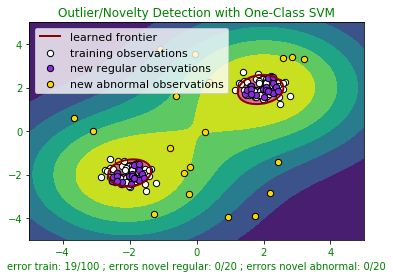

In [20]:
plt.title("Outlier/Novelty Detection with One-Class SVM", color='green')
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7))
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s, edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s, edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(
    [a.collections[0], b1, b2, c],
    ["learned frontier", "training observations", "new regular observations", "new abnormal observations"],
    loc="upper left",
    prop=matplotlib.font_manager.FontProperties(size=11)
)
plt.xlabel("error train: %d/100 ; errors novel regular: %d/20 ; errors novel abnormal: %d/20" % (n_error_train, n_error_test, n_error_outliers), color='green')

[i.set_color("green") for i in plt.gca().get_xticklabels()]
[i.set_color("green") for i in plt.gca().get_yticklabels()]

plt.show()

### TODO: comment

# Part III: Proximity-Based Outlier Detection

## The Local Outlier Factor (LOF)

### TODO: comment

In [54]:
n_samples = 200
outliers_fraction = 0.25

### TODO: comment

In [55]:
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))

### TODO: comment

In [56]:
n_inliers = int((1. - outliers_fraction) * n_samples)

### TODO: comment

In [57]:
n_outliers = int(outliers_fraction * n_samples)

### TODO: comment

In [58]:
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

### TODO: comment

In [59]:
clf = LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction)

### TODO: comment

In [60]:
X1 = 0.3 * np.random.randn(n_inliers // 2, 2)
X2 = 0.3 * np.random.randn(n_inliers // 2, 2)

### TODO: comment

In [61]:
X = np.r_[X1, X2]
X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

### TODO: comment

In [62]:
y_pred = clf.fit_predict(X)
scores_pred = clf.negative_outlier_factor_

### TODO: comment

In [63]:
threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)

### TODO: comment

In [64]:
n_errors = (y_pred != ground_truth).sum()

### TODO: comment

In [65]:
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])

### TODO: comment

In [66]:
Z = Z.reshape(xx.shape)

### TODO: comment

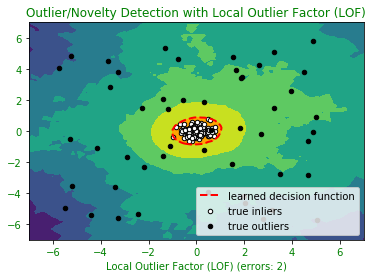

In [67]:
plt.title("Outlier/Novelty Detection with Local Outlier Factor (LOF)", color='green')
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7))
a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
b = plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white', s=20, edgecolor='k')
c = plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black', s=20, edgecolor='k')
plt.axis('tight')
plt.legend(
    [a.collections[0], b, c],
    ['learned decision function', 'true inliers', 'true outliers'],
    prop=matplotlib.font_manager.FontProperties(size=10),
    loc='lower right'
)
plt.xlabel("%s (errors: %d)" % ("Local Outlier Factor (LOF)", n_errors), color='green')
plt.xlim((-7, 7))
plt.ylim((-7, 7))

[i.set_color("green") for i in plt.gca().get_xticklabels()]
[i.set_color("green") for i in plt.gca().get_yticklabels()]

plt.show()

# Part IV: High-Dimensional Outlier Detection